# For a Better Criminal Justice System: Analyzing Recidivism and Prison Populations in the US

#### Data sourced from:
- [Sentencing Project, State Imprisonment Rate](https://www.sentencingproject.org/the-facts/#rankings)
    - "Research on incarceration has traditionally centered on state-level data: specifically state prison populations or the statewide combined prison and jail population. Using the state as the unit of analysis is sufficient for understanding the broad contours of incarceration in the United States, but it does not provide the level of detail necessary to unpack its causes and consequences."
    
-[Bureau of Justice Statistics, National Prisoners Statistics Program](https://www.kaggle.com/christophercorrea/prisoners-and-crime-in-united-states?select=crime_and_incarceration_by_state.csv)

    - "The Bureau of Justice Statistics administers the National Prisoners Statistics Program (NPS), an annual data collection effort that began in response to a 1926 congressional mandate. The population statistics reflect each state's prisoner population as of December 31 for the recorded year. Prisoners listed under federal jurisdiction are incarcerated by the U.S. Bureau of Prisons."
    
- [Iowa Department of Corrections](https://data.iowa.gov/Correctional-System/3-Year-Recidivism-for-Offenders-Released-from-Pris/mw8r-vqy4), [Kaggle, slonnadube](https://www.kaggle.com/slonnadube/recidivism-for-offenders-released-from-prison)
    - "This dataset reports whether an offender is re-admitted to prison or not within three years from being released from prison in Iowa. The recidivism reporting year is the fiscal year (year ending June 30) marking the end of the three year tracking period.
       The Department of Corrections uses recidivism as an indicator on whether strategies are reducing offenders relapse into criminal behavior. A three year time frame is used as studies have shown if an offender relapses into criminal behavior it is most likely to happen within three years of being released."
       
- [Prison Policy Initiative](https://www.prisonpolicy.org/profiles/)

In [40]:
## Auto EDA
from ClfAutoEDA import *

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
from matplotlib.patches import Patch
from matplotlib import pyplot
plt.style.use('ggplot')
from imblearn.over_sampling import SMOTE

import pandas as pd
from pandas import Grouper
from pandas.plotting import lag_plot

from pandas import datetime


import seaborn as sns

## Time series libraries
from darts import TimeSeries
from darts.models import ExponentialSmoothing
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller, Mapper, InvertibleMapper

import statsmodels.api as sm
import plotly.express as px
from statsmodels.tsa.statespace.tools import diff as diff
from statsmodels.tsa.stattools import adfuller
import altair as alt

### 1. Auto EDA, Prep for Focused EDA
### 2. Focused EDA, Data Touch-up


## 1. Auto EDA, Prep for Focused EDA

In [41]:
data=pd.read_csv('data_for_EDA.csv')
data.head()

,Fiscal Year Released,Recidivism Reporting Year,Ethnicity,Sex,Age At Release,Convicting Offense Classification,Convicting Offense Type,Convicting Offense Subtype,Release Type,Part of Target Population,Recidivism
0,2010,2013,White - Non-Hispanic,Male,Under 25,D Felony,Violent,Assault,Parole,Yes,1
1,2010,2013,White - Non-Hispanic,Male,55 and Older,D Felony,Public Order,OWI,Parole,Yes,1
2,2010,2013,White - Non-Hispanic,Male,25-34,D Felony,Property,Burglary,Parole,Yes,1
3,2010,2013,White - Non-Hispanic,Male,55 and Older,C Felony,Drug,Trafficking,Parole,Yes,1
4,2010,2013,Black - Non-Hispanic,Male,25-34,D Felony,Drug,Trafficking,Parole,Yes,1


The data looks like this: 
    Fiscal Year Released  Recidivism Reporting Year             Ethnicity  \
0                  2010                       2013  White - Non-Hispanic   
1                  2010                       2013  White - Non-Hispanic   
2                  2010                       2013  White - Non-Hispanic   
3                  2010                       2013  White - Non-Hispanic   
4                  2010                       2013  Black - Non-Hispanic   

    Sex Age At Release  Convicting Offense Classification  \
0  Male        Under 25                          D Felony   
1  Male    55 and Older                          D Felony   
2  Male           25-34                          D Felony   
3  Male    55 and Older                          C Felony   
4  Male           25-34                          D Felony   

  Convicting Offense Type Convicting Offense Subtype Release Type  \
0                 Violent                    Assault       Parole   
1         

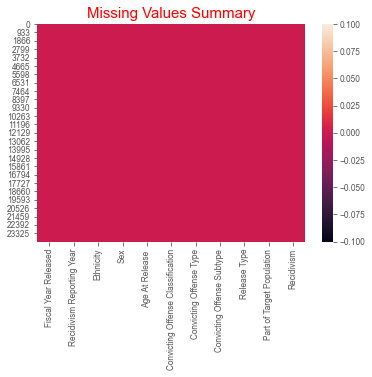

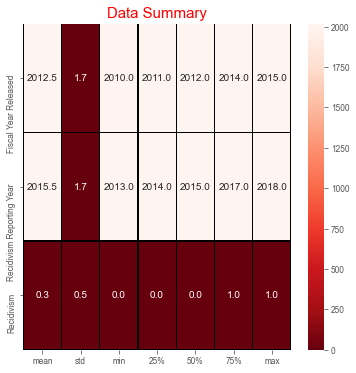

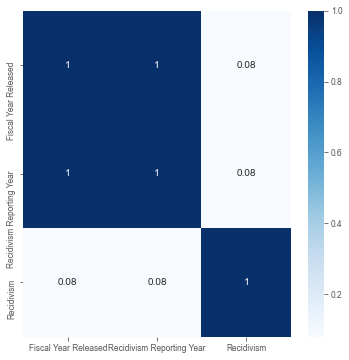

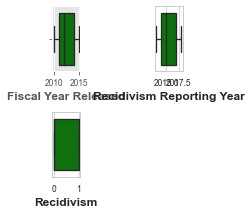

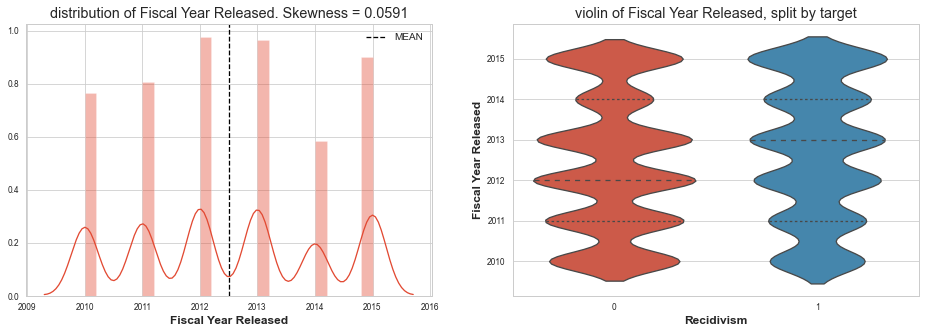

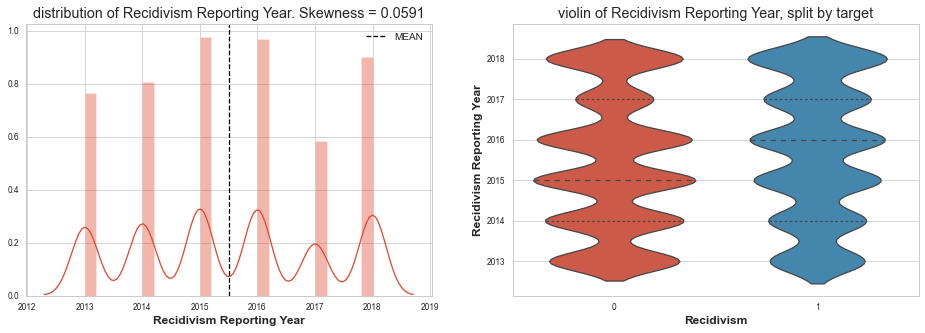

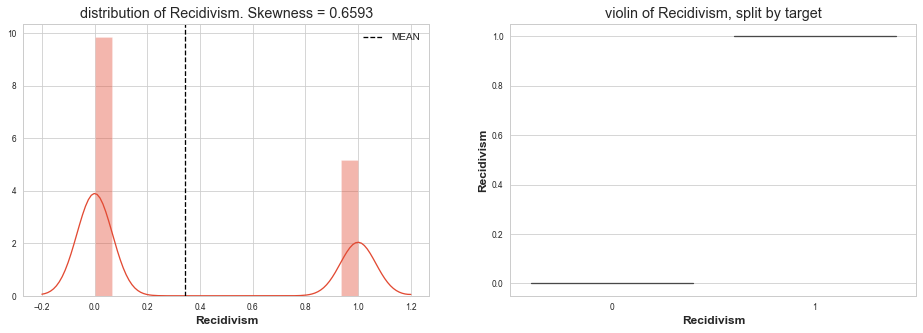

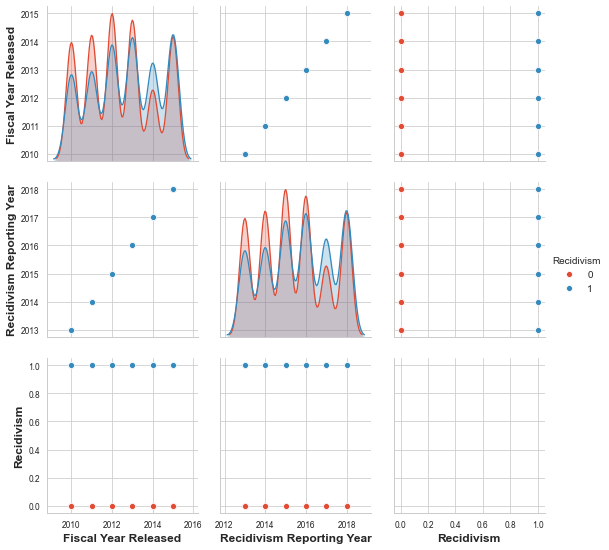

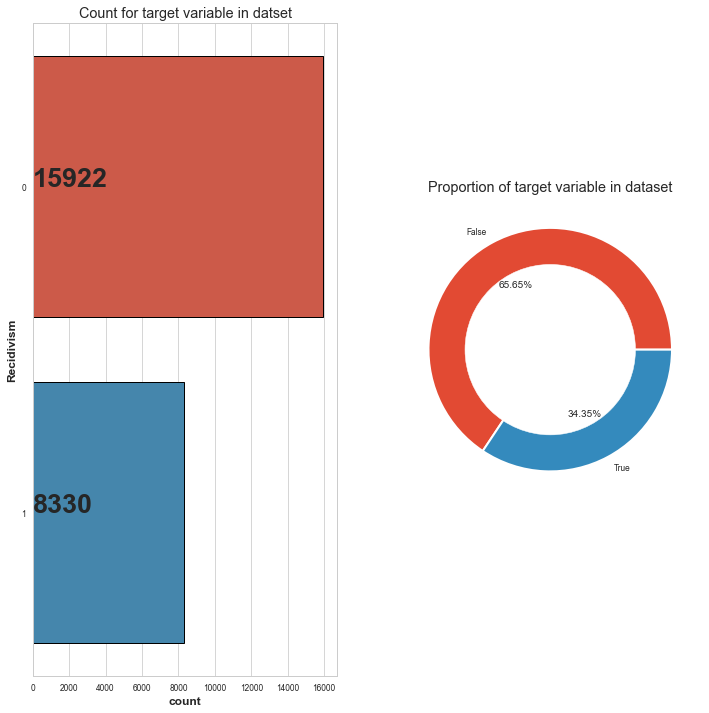

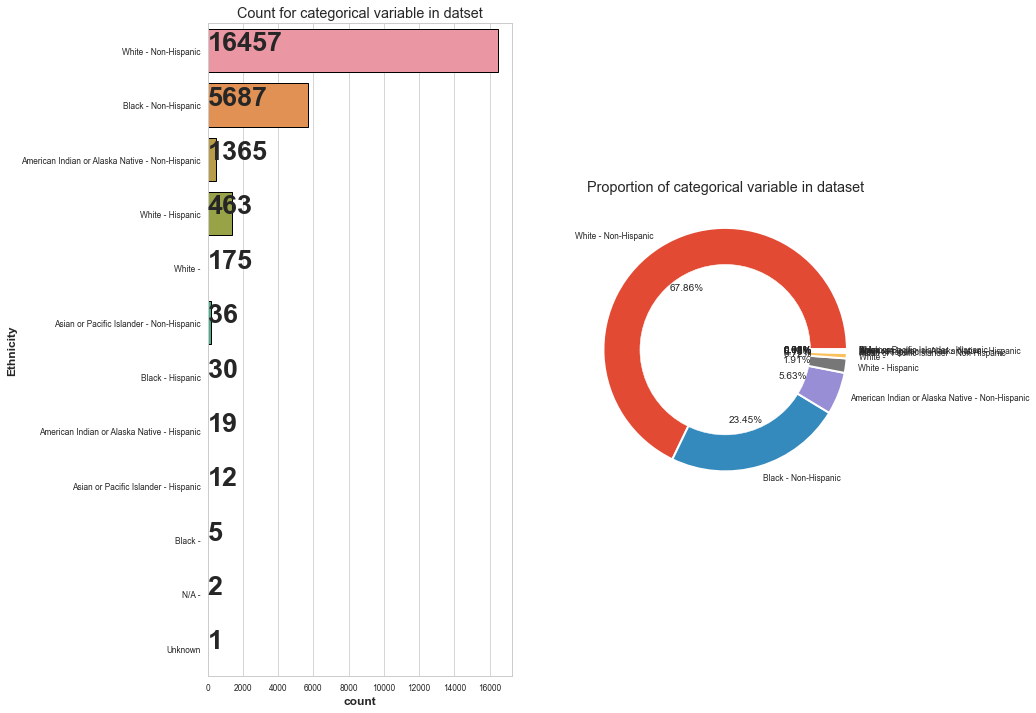

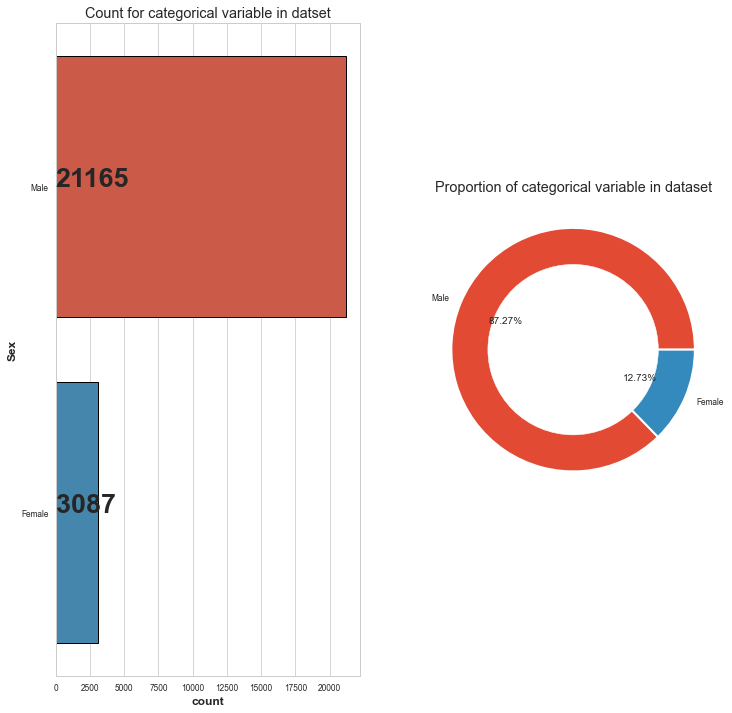

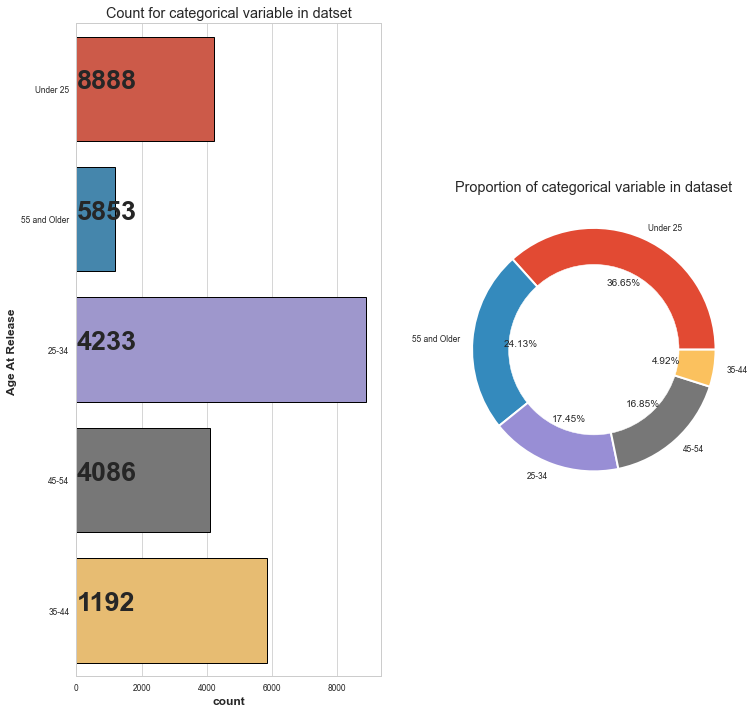

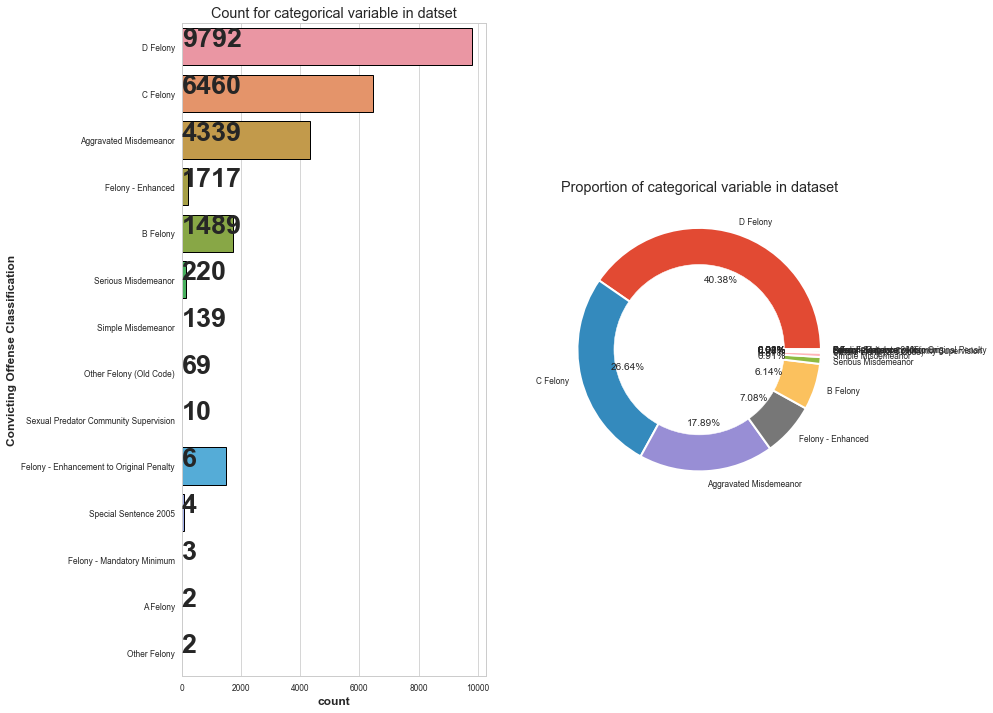

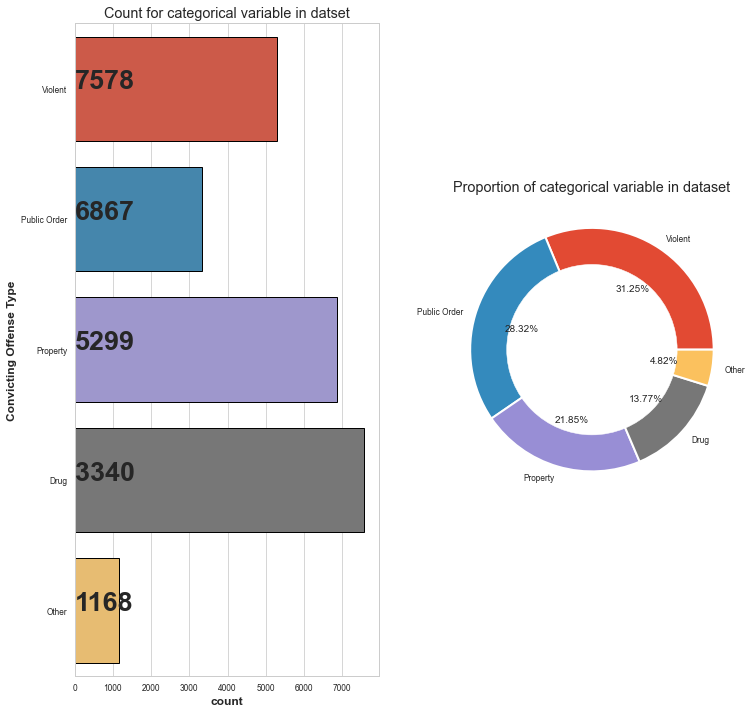

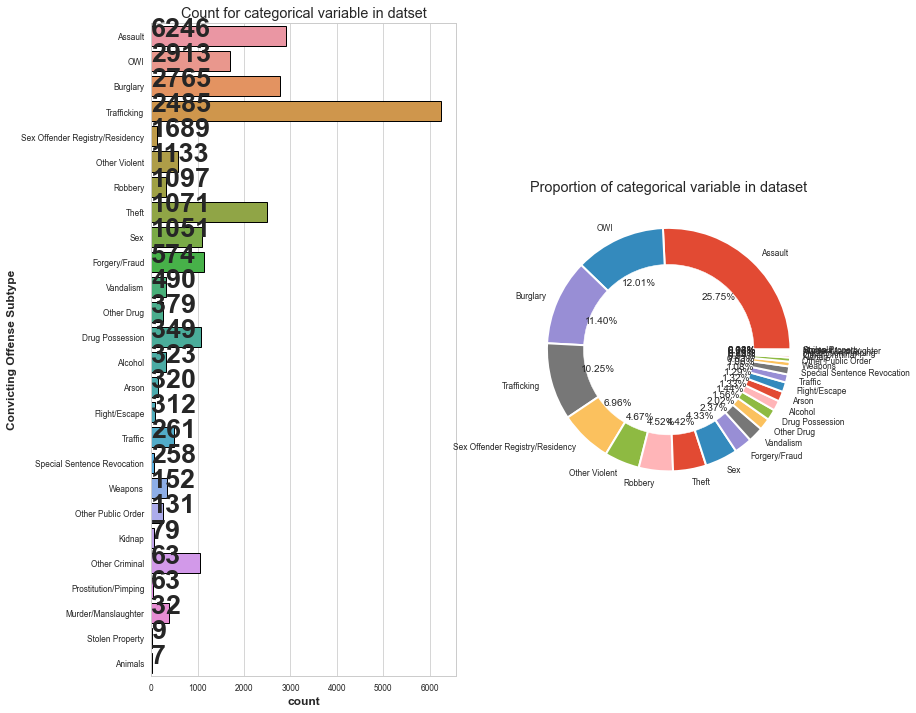

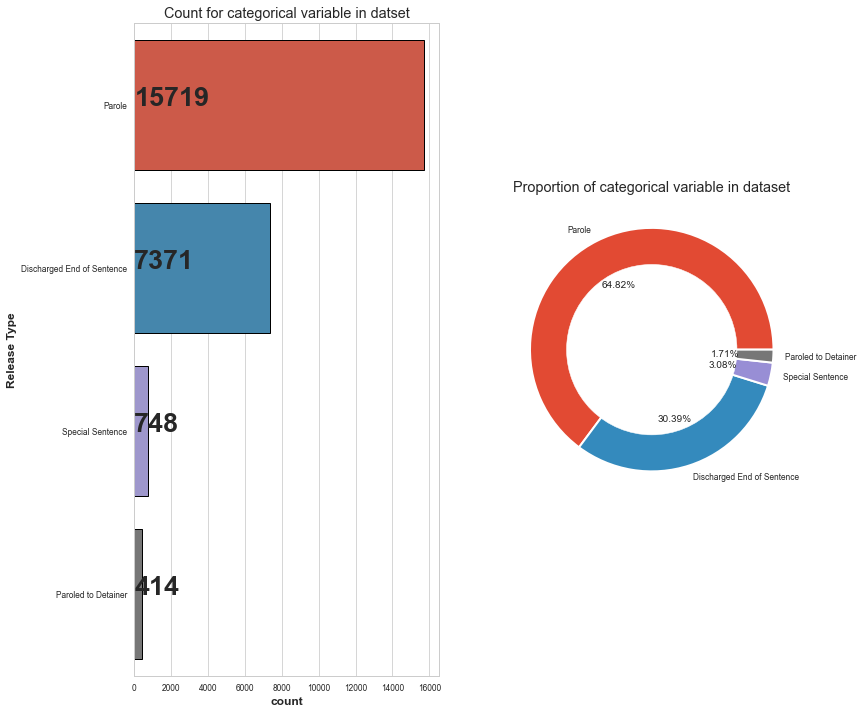

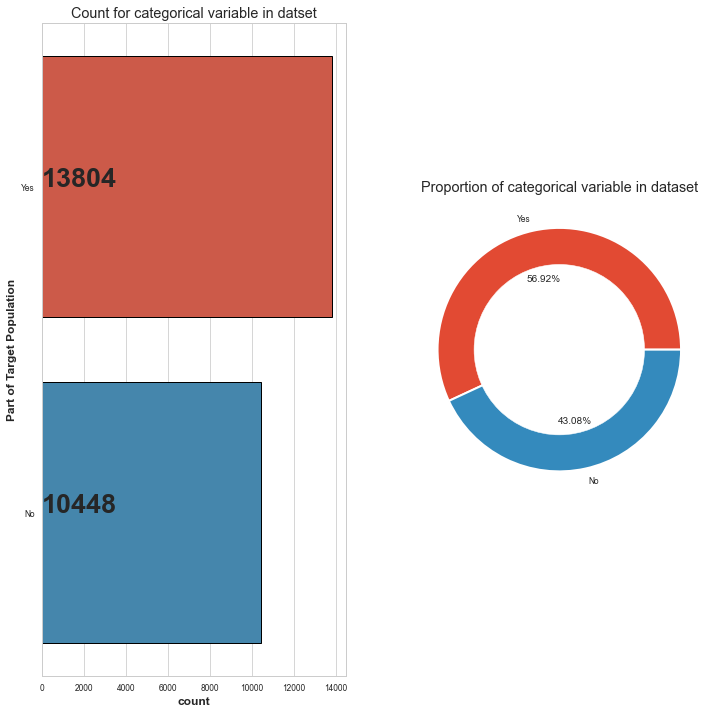

In [42]:
labels=["False","True"]
target_variable_name='Recidivism'
data,num_features,cat_features=EDA(data,labels,
                                         target_variable_name,
                                         data_summary_figsize=(6,6),
                                         corr_matrix_figsize=(6,6),
                                         corr_matrix_annot=True,
                                         pairplt=True)

#### Takeaways: 
1. 'Convicting Offense Classification' may need cleaning 
2. 'Part of Target Population' needs further analysis
3. 'Ethnicity' may need cleaning

## 2. Focused EDA, Data Touch-up

##### General Overview of Recidivism

Recidivism Count
Recidivism
0    15922
1     8330
Name: Recidivism, dtype: int64


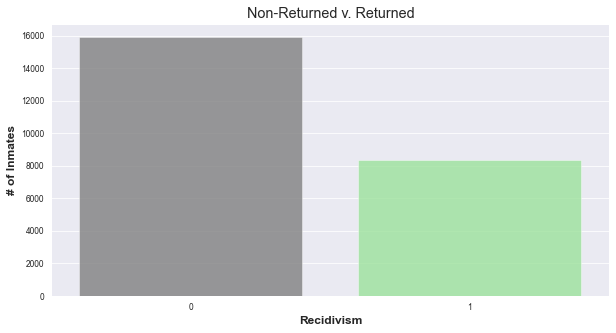

In [43]:
# breakdown of recidivism distribution
print('Recidivism Count')
print(data.groupby(['Recidivism']).Recidivism.count())

sns.set_style('darkgrid')
plt.figure(figsize = (10,5))
sns.countplot(data['Recidivism'], alpha =.80, palette= ['grey','lightgreen'])
plt.title('Non-Returned v. Returned')
plt.ylabel('# of Inmates')
plt.show()

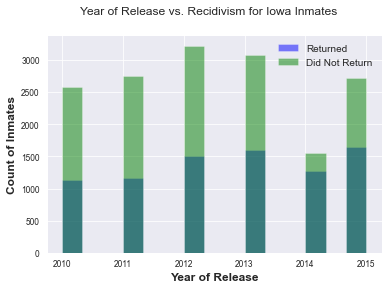

In [44]:
# breakdown of recidivism distribution across release years
fig, ax = plt.subplots()

ax.hist(data[data["Recidivism"]==1]["Fiscal Year Released"], bins=15, alpha=0.5, color="blue", label="Returned")
ax.hist(data[data["Recidivism"]==0]["Fiscal Year Released"], bins=15, alpha=0.5, color="green", label="Did Not Return")

ax.set_xlabel("Year of Release")
ax.set_ylabel("Count of Inmates")

fig.suptitle("Year of Release vs. Recidivism for Iowa Inmates")

ax.legend();

##### Convicting offense type and classification investigation 

In [45]:
data['Convicting Offense Classification'].value_counts()

D Felony                                    9792
C Felony                                    6460
Aggravated Misdemeanor                      4339
B Felony                                    1717
Felony - Enhancement to Original Penalty    1489
Felony - Enhanced                            220
Serious Misdemeanor                          139
Special Sentence 2005                         69
Felony - Mandatory Minimum                    10
Other Felony                                   6
A Felony                                       4
Simple Misdemeanor                             3
Other Felony (Old Code)                        2
Sexual Predator Community Supervision          2
Name: Convicting Offense Classification, dtype: int64

In [46]:
# taking a closer look at 'convicting offense classification' to see if we can combine or eliminate certain rows
pie_me = data['Convicting Offense Classification'].value_counts().reset_index()
pie_me.columns = ['Convicting Offense Classification', 'count']

fig = px.pie(
    pie_me, 
    values='count', 
    names='Convicting Offense Classification',  
    title='Offense Classification', 
    width=600, 
    height=600
)

fig.show()

Text(0.5, 0.98, 'Recidivism with Convicting Offense Classification')

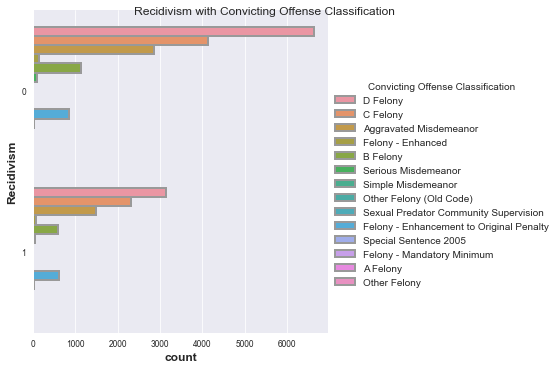

In [47]:
# checking recidivism and 'convicting offense classification'
ax = sns.catplot(y="Recidivism", hue="Convicting Offense Classification", kind="count",
            edgecolor=".6",
            data=data, linewidth=2)
ax.fig.suptitle('Recidivism with Convicting Offense Classification')

In [48]:
pd.crosstab(data['Convicting Offense Classification'], data['Recidivism'], normalize='index')

Recidivism,0,1
Convicting Offense Classification,,
A Felony,1.000000,0.000000
Aggravated Misdemeanor,0.657064,0.342936
B Felony,0.660454,0.339546
C Felony,0.640402,0.359598
D Felony,0.677900,0.322100
Felony - Enhanced,0.650000,0.350000
Felony - Enhancement to Original Penalty,0.580927,0.419073
Felony - Mandatory Minimum,0.800000,0.200000
Other Felony,0.500000,0.500000


Convicting Offense Type
Convicting Offense Type
Drug            7578
Other           1168
Property        6867
Public Order    3340
Violent         5299
Name: Convicting Offense Type, dtype: int64


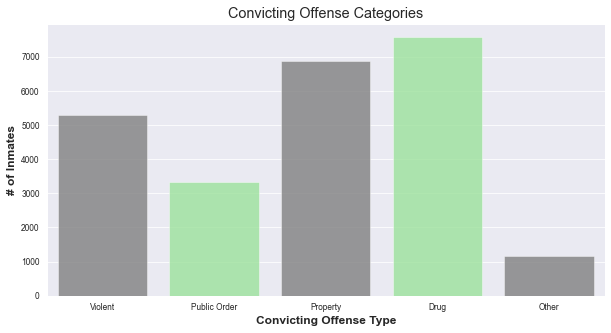

In [49]:
# overview of 'convicting offense type' - will be a useful category to cross reference against other features
print('Convicting Offense Type')
print(data.groupby(['Convicting Offense Type'])['Convicting Offense Type'].count())

sns.set_style('darkgrid')
plt.figure(figsize = (10,5))
sns.countplot(data['Convicting Offense Type'], alpha =.80, palette= ['grey','lightgreen'])
plt.title('Convicting Offense Categories')
plt.ylabel('# of Inmates')
plt.show()

In [50]:
##### Cleaning/investigating ethnicity and recidivism 

In [51]:
# overview of ethnicity and recidivism 
pie_me = data['Ethnicity'].value_counts().reset_index()
pie_me.columns = ['Ethnicity', 'count']

fig = px.pie(
    pie_me, 
    values='count', 
    names='Ethnicity',  
    title='Ethnicity Distribution', 
    width=600, 
    height=600
)

fig.show()

In [52]:
# checking if we need to clean or combine any rows
data['Ethnicity'].value_counts()

White - Non-Hispanic                               16457
Black - Non-Hispanic                                5687
White - Hispanic                                    1365
American Indian or Alaska Native - Non-Hispanic      463
Asian or Pacific Islander - Non-Hispanic             175
Black - Hispanic                                      36
Unknown                                               30
American Indian or Alaska Native - Hispanic           19
White -                                               12
Asian or Pacific Islander - Hispanic                   5
Black -                                                2
N/A -                                                  1
Name: Ethnicity, dtype: int64

##### Converting ethnicity values with a count of less than 4 into 'other,' dropping 'White -' values and 'Other' values

In [53]:
data[['Ethnicity']] = data[['Ethnicity']].where(data.apply(lambda x: x.groupby(x).transform('count')>4), 'Other')

In [54]:
data = data[data['Ethnicity'] != 'White -']

In [55]:
data = data[data['Ethnicity'] != 'Other']

##### Taking a closer look at ethnicity and recidivism

In [56]:
data['Ethnicity'].value_counts()

White - Non-Hispanic                               16457
Black - Non-Hispanic                                5687
White - Hispanic                                    1365
American Indian or Alaska Native - Non-Hispanic      463
Asian or Pacific Islander - Non-Hispanic             175
Black - Hispanic                                      36
Unknown                                               30
American Indian or Alaska Native - Hispanic           19
Asian or Pacific Islander - Hispanic                   5
Name: Ethnicity, dtype: int64

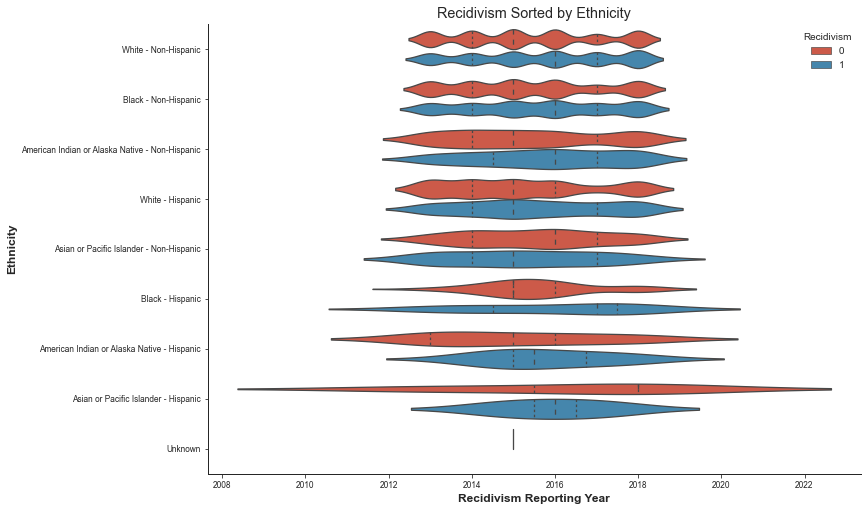

In [57]:
# plotting ethnicity by reporting year 
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.violinplot(x="Recidivism Reporting Year", y="Ethnicity", hue="Recidivism",
            kind="violin", data=data, inner="quart", ax=ax).set_title('Recidivism Sorted by Ethnicity')    
sns.despine()

In [58]:
pd.crosstab(data.Ethnicity, data.Recidivism, normalize='index')

Recidivism,0,1
Ethnicity,,
American Indian or Alaska Native - Hispanic,0.684211,0.315789
American Indian or Alaska Native - Non-Hispanic,0.596112,0.403888
Asian or Pacific Islander - Hispanic,0.600000,0.400000
Asian or Pacific Islander - Non-Hispanic,0.748571,0.251429
Black - Hispanic,0.694444,0.305556
Black - Non-Hispanic,0.654651,0.345349
Unknown,1.000000,0.000000
White - Hispanic,0.778022,0.221978
White - Non-Hispanic,0.646837,0.353163


##### Dropping 'unknown' from 'Ethnicity' as it does not provide any useful insights. 

In [59]:
data = data[data['Ethnicity'] != 'Unknown']

In [60]:
data['Ethnicity'].value_counts()

White - Non-Hispanic                               16457
Black - Non-Hispanic                                5687
White - Hispanic                                    1365
American Indian or Alaska Native - Non-Hispanic      463
Asian or Pacific Islander - Non-Hispanic             175
Black - Hispanic                                      36
American Indian or Alaska Native - Hispanic           19
Asian or Pacific Islander - Hispanic                   5
Name: Ethnicity, dtype: int64

Text(0.5, 0.98, 'Recidvism Distribution Sorted by Sex and Ethnicity')

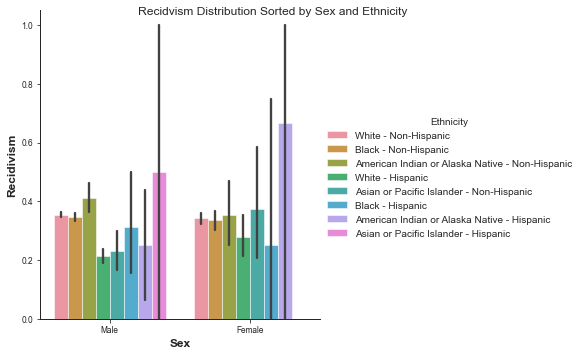

In [61]:
# ethnicity/sex offense type
ax = sns.catplot(x="Sex", y="Recidivism", hue="Ethnicity", kind="bar", data=data)
ax.fig.suptitle('Recidvism Distribution Sorted by Sex and Ethnicity')

##### Recidivism and Release Type

Text(0.5, 0.98, 'Recidivism with Release Type')

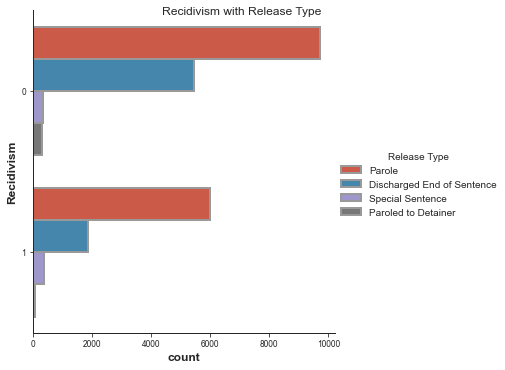

In [62]:
ax = sns.catplot(y="Recidivism", hue="Release Type", kind="count",
            edgecolor=".6",
            data=data, linewidth=2)
ax.fig.suptitle('Recidivism with Release Type')

In [63]:
pd.crosstab(data['Release Type'], data['Recidivism'], normalize='index')

Recidivism,0,1
Release Type,,
Discharged End of Sentence,0.745464,0.254536
Parole,0.619129,0.380871
Paroled to Detainer,0.782609,0.217391
Special Sentence,0.481283,0.518717


##### Deep dive into sex and recidivism

In [64]:
pie_me = data['Sex'].value_counts().reset_index()
pie_me.columns = ['Sex', 'count']

fig = px.pie(
    pie_me, 
    values='count', 
    names='Sex',  
    title='Sex Distribution', 
    width=600, 
    height=600
)

fig.show()

In [65]:
pd.crosstab(data['Sex'], data['Recidivism'], normalize='index')

Recidivism,0,1
Sex,,
Female,0.662342,0.337658
Male,0.654990,0.345010


Text(0.5, 0.98, 'Recidvism Distribution Sorted by Sex and Convicting Offense Type')

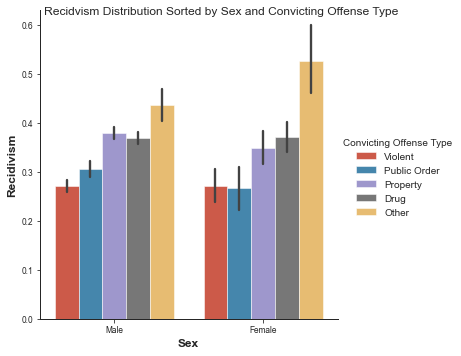

In [66]:
# sex/convicting offense type
ax = sns.catplot(x="Sex", y="Recidivism", hue="Convicting Offense Type", kind="bar", data=data)
ax.fig.suptitle('Recidvism Distribution Sorted by Sex and Convicting Offense Type')

Text(0.5, 0.98, 'Recidivism Sorted by Sex and Release Age')

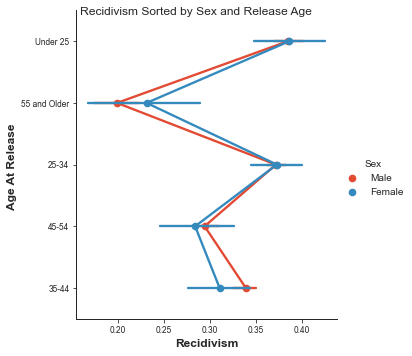

In [67]:
ax = sns.catplot(x="Recidivism", y="Age At Release ", hue="Sex", kind="point", data=data)
ax.fig.suptitle('Recidivism Sorted by Sex and Release Age')